# Unit06_Kernel_PCA | 副標題：化工製程的非線性降維分析

本 Notebook 使用 `Part_2/data/reactor_operation/` 中的模擬數據建立 **Kernel PCA (核主成分分析)** 模型來進行非線性降維分析與製程監控。

## 目標
- 理解 Kernel PCA 的核心原理與數學基礎
- 掌握核函數的選擇與超參數調整方法
- 學會使用 scikit-learn 實作 Kernel PCA 模型
- 比較線性 PCA 與 Kernel PCA 的效果差異
- 應用 Kernel PCA 於化工製程的非線性特徵提取

資料背景：模擬化工反應器的非線性操作數據，包含溫度、壓力、流量、濃度等製程變數

---
## 0. 環境設定

In [14]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit06_Kernel_PCA'
SOURCE_DATA_DIR = 'reactor_operation'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit06'
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    print(f"✓ Notebook 目錄: {NOTEBOOK_DIR}")
    print(f"✓ 數據目錄: {DATA_DIR}")
    print(f"✓ 輸出目錄: {OUTPUT_DIR}")
  else:
    raise FileNotFoundError(f"找不到 Google Drive 中的課程資料夾：{source_path}")
else:
  NOTEBOOK_DIR = Path.cwd()
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  print(f"✓ Notebook 目錄: {NOTEBOOK_DIR}")
  print(f"✓ 數據目錄: {DATA_DIR}")
  print(f"✓ 輸出目錄: {OUTPUT_DIR}")

# ========================================
# 建立輸出資料夾
# ========================================
FIG_DIR = OUTPUT_DIR / 'figs'
MODEL_DIR = OUTPUT_DIR / 'models'

for dir_path in [OUTPUT_DIR, FIG_DIR, MODEL_DIR]:
  dir_path.mkdir(parents=True, exist_ok=True)

print(f"\n✓ 圖片輸出目錄: {FIG_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")

✓ 偵測到 Local 環境
✓ Notebook 目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06
✓ 數據目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\data\reactor_operation
✓ 輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_Kernel_PCA

✓ 圖片輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_Kernel_PCA\figs
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_Kernel_PCA\models


---
## 1. 載入相關套件

In [15]:
# 數據處理
import numpy as np
import pandas as pd

# 視覺化
import matplotlib.pyplot as plt
import seaborn as sns

# 機器學習
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# 模型儲存
import joblib

# 警告訊息處理
import warnings
warnings.filterwarnings('ignore')

# 設定隨機種子
np.random.seed(42)

# 設定圖表風格
plt.style.use('default')
sns.set_palette("husl")

print("✓ 所有套件載入完成")

✓ 所有套件載入完成


---
## 2. 生成模擬數據

**情境說明**：
模擬化工反應器的**非線性操作數據**，特別設計能展示 Kernel PCA 優勢的數據結構：

- **模式 A (Bimodal - 雙峰分佈)**：
  - 內環操作（徑向距離 ≈ 2）：低溫低壓穩態
  - 外環操作（徑向距離 ≈ 5）：高溫高壓動態
  - 代表反應器在兩種極端條件下的操作模式
  - 樣本分佈在內圈和外圈

- **模式 B (Middle - 中間環)**：
  - 中環操作（徑向距離 ≈ 3.5）：中等溫壓過渡態
  - 代表反應器在中等條件下的穩定操作
  - 樣本分佈在中間圓環

**關鍵挑戰（為何傳統 PCA 失敗）**：
- 在任何**線性投影方向**上，模式 A 的內環與模式 B 會重疊
- 同時，模式 A 的外環也會與模式 B 在某些方向上重疊
- 傳統 PCA 無法利用「徑向距離模式」這一非線性特徵
- **只有非線性核函數（如 RBF）能識別「雙峰 vs 單峰」的徑向分佈差異**

**數據包含以下製程變數**：
- 反應器溫度 (Temperature, °C)
- 反應器壓力 (Pressure, bar)
- 進料流量 (Feed Flow Rate, kg/h)
- 反應物A濃度 (Concentration A, mol/L)
- 反應物B濃度 (Concentration B, mol/L)
- 產物濃度 (Product Concentration, mol/L)

所有變數之間存在**基於徑向距離和角度的複雜非線性關係**。

In [16]:
def generate_nonlinear_reactor_data(n_samples=400, noise_level=0.15, random_seed=42):
    """
    生成具有明顯非線性關係的反應器數據
    設計理念：創建「內外雙環」結構，線性投影會混淆但非線性核可以分離
    
    兩種操作模式：
    - 模式 A：內環 (radius ≈ 2) + 外環 (radius ≈ 5) - 分佈在兩個同心圓上
    - 模式 B：中環 (radius ≈ 3.5) - 分佈在中間圓上
    
    這種結構在任何線性投影下都會造成混淆，但 RBF kernel 可以識別徑向模式
    
    Parameters:
    -----------
    n_samples : int
        樣本數量
    noise_level : float
        噪音強度
    random_seed : int
        隨機種子
    
    Returns:
    --------
    df : pd.DataFrame
        生成的數據
    """
    np.random.seed(random_seed)
    
    # ========================================
    # 模式 A：內環 + 外環（雙峰分佈）
    # ========================================
    n_mode_a = n_samples // 2
    n_inner = n_mode_a // 2  # 一半在內環
    n_outer = n_mode_a - n_inner  # 一半在外環
    
    # 內環部分 (radius ≈ 2.0)
    theta_inner = np.linspace(0, 2*np.pi, n_inner, endpoint=False) + noise_level * 2 * np.random.randn(n_inner)
    radius_inner = 2.0 + noise_level * np.random.randn(n_inner)
    x1_inner = radius_inner * np.cos(theta_inner)
    x2_inner = radius_inner * np.sin(theta_inner)
    
    # 外環部分 (radius ≈ 5.0)
    theta_outer = np.linspace(0, 2*np.pi, n_outer, endpoint=False) + noise_level * 2 * np.random.randn(n_outer)
    radius_outer = 5.0 + noise_level * np.random.randn(n_outer)
    x1_outer = radius_outer * np.cos(theta_outer)
    x2_outer = radius_outer * np.sin(theta_outer)
    
    # 合併模式 A 的內外環
    x1_a = np.concatenate([x1_inner, x1_outer])
    x2_a = np.concatenate([x2_inner, x2_outer])
    radius_a = np.concatenate([radius_inner, radius_outer])
    
    # ========================================
    # 模式 B：中環（單峰分佈）
    # ========================================
    n_mode_b = n_samples - n_mode_a
    theta_b = np.linspace(0, 2*np.pi, n_mode_b, endpoint=False) + noise_level * 2 * np.random.randn(n_mode_b)
    radius_b = 3.5 + noise_level * np.random.randn(n_mode_b)
    x1_b = radius_b * np.cos(theta_b)
    x2_b = radius_b * np.sin(theta_b)
    
    # ========================================
    # 合併所有數據
    # ========================================
    x1 = np.concatenate([x1_a, x1_b])
    x2 = np.concatenate([x2_a, x2_b])
    radial_distance = np.sqrt(x1**2 + x2**2)
    angle = np.arctan2(x2, x1)
    
    # ========================================
    # 基於位置生成化工變數
    # ========================================
    
    # 溫度：與徑向距離和角度的複雜非線性關係
    temperature = 320 + 15 * radial_distance + 8 * np.sin(2*angle) * radial_distance + noise_level * 10 * np.random.randn(n_samples)
    
    # 壓力：非線性函數
    pressure = 10 + 0.3 * radial_distance**2 - 2 * radial_distance * np.cos(angle) + noise_level * 0.8 * np.random.randn(n_samples)
    
    # 進料流量：角度和徑向的交互作用
    feed_flow = 1000 + 40 * radial_distance * (1 + 0.3*np.cos(3*angle)) + noise_level * 35 * np.random.randn(n_samples)
    
    # 濃度 A：徑向二次函數
    conc_a = 8 + 0.6 * radial_distance**2 + noise_level * 1.5 * np.random.randn(n_samples)
    
    # 濃度 B：複雜非線性
    conc_b = 6 + 0.4 * radial_distance**2 * np.cos(angle) + 0.5 * radial_distance * np.sin(2*angle) + noise_level * 1.2 * np.random.randn(n_samples)
    
    # 產物濃度：交互項
    product_conc = 1.0 + 0.02 * conc_a * conc_b + noise_level * 0.4 * np.random.randn(n_samples)
    
    # ========================================
    # 組織為 DataFrame
    # ========================================
    mode_labels = ['Mode A (Bimodal)'] * n_mode_a + ['Mode B (Middle)'] * n_mode_b
    
    df = pd.DataFrame({
        'Temperature (°C)': temperature,
        'Pressure (bar)': pressure,
        'Feed Flow Rate (kg/h)': feed_flow,
        'Concentration A (mol/L)': conc_a,
        'Concentration B (mol/L)': conc_b,
        'Product Concentration (mol/L)': product_conc,
        'Mode': mode_labels
    })
    
    return df

# 生成訓練和測試數據
df_train = generate_nonlinear_reactor_data(n_samples=400, noise_level=0.15, random_seed=42)
df_test = generate_nonlinear_reactor_data(n_samples=100, noise_level=0.15, random_seed=123)

print("✓ 訓練數據生成完成")
print(f"  - 樣本數: {len(df_train)}")
print(f"  - 特徵數: {len(df_train.columns) - 1}")
print(f"  - 模式 A 樣本數: {(df_train['Mode'] == 'Mode A (Bimodal)').sum()}")
print(f"  - 模式 B 樣本數: {(df_train['Mode'] == 'Mode B (Middle)').sum()}")

print("\n✓ 測試數據生成完成")
print(f"  - 樣本數: {len(df_test)}")

print("\n數據結構說明：")
print("  - 模式 A：雙峰分佈（內環 + 外環），代表兩種極端操作條件")
print("  - 模式 B：單峰分佈（中環），代表中等操作條件")
print("  - 線性投影無法區分：內環與中環、外環與中環會混淆")
print("  - RBF kernel 可識別：基於徑向距離的模式識別\n")

print("訓練數據概覽:")
display(df_train.head(10))
print("\n數據統計:")
display(df_train.describe())

✓ 訓練數據生成完成
  - 樣本數: 400
  - 特徵數: 6
  - 模式 A 樣本數: 200
  - 模式 B 樣本數: 200

✓ 測試數據生成完成
  - 樣本數: 100

數據結構說明：
  - 模式 A：雙峰分佈（內環 + 外環），代表兩種極端操作條件
  - 模式 B：單峰分佈（中環），代表中等操作條件
  - 線性投影無法區分：內環與中環、外環與中環會混淆
  - RBF kernel 可識別：基於徑向距離的模式識別

訓練數據概覽:


,Temperature (°C),Pressure (bar),Feed Flow Rate (kg/h),Concentration A (mol/L),Concentration B (mol/L),Product Concentration (mol/L),Mode
0,352.422296,7.438016,1089.891770,9.765596,7.396727,2.455699,Mode A (Bimodal)
1,348.941005,7.201026,1107.889397,10.218440,7.573469,2.709363,Mode A (Bimodal)
2,358.681856,7.454397,1087.964793,10.099914,7.925115,2.621848,Mode A (Bimodal)
3,361.953164,8.121976,1062.930475,10.050578,7.983314,2.544495,Mode A (Bimodal)
4,354.585552,7.290004,1096.794232,9.916225,8.187227,2.618000,Mode A (Bimodal)
5,358.172070,7.279478,1095.816514,10.595653,8.372369,2.667640,Mode A (Bimodal)
6,372.684739,8.468492,1069.187162,11.127327,8.272488,2.836178,Mode A (Bimodal)
7,365.454764,7.975878,1079.234631,10.279415,8.422724,2.681630,Mode A (Bimodal)
8,363.261444,7.265204,1094.654364,10.641944,8.375726,2.837604,Mode A (Bimodal)
9,364.297455,8.427906,1064.478907,10.584228,7.962084,2.652478,Mode A (Bimodal)



數據統計:


,Temperature (°C),Pressure (bar),Feed Flow Rate (kg/h),Concentration A (mol/L),Concentration B (mol/L),Product Concentration (mol/L)
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,373.360128,14.032023,1139.532348,16.058372,6.047627,2.942697
std,26.591591,5.684491,52.128418,4.598720,4.580392,1.991607
min,332.324367,6.433364,1046.688459,9.397244,-5.686609,-1.655490
25%,352.771297,8.850632,1100.432902,13.063025,3.531846,1.842527
50%,367.528186,13.160660,1135.936894,15.324787,6.086626,2.534728
75%,391.612900,18.477086,1173.837644,18.147748,8.623150,3.781576
max,441.234436,27.813467,1273.269343,25.490870,18.093099,9.648605


### 2.1 數據視覺化探索

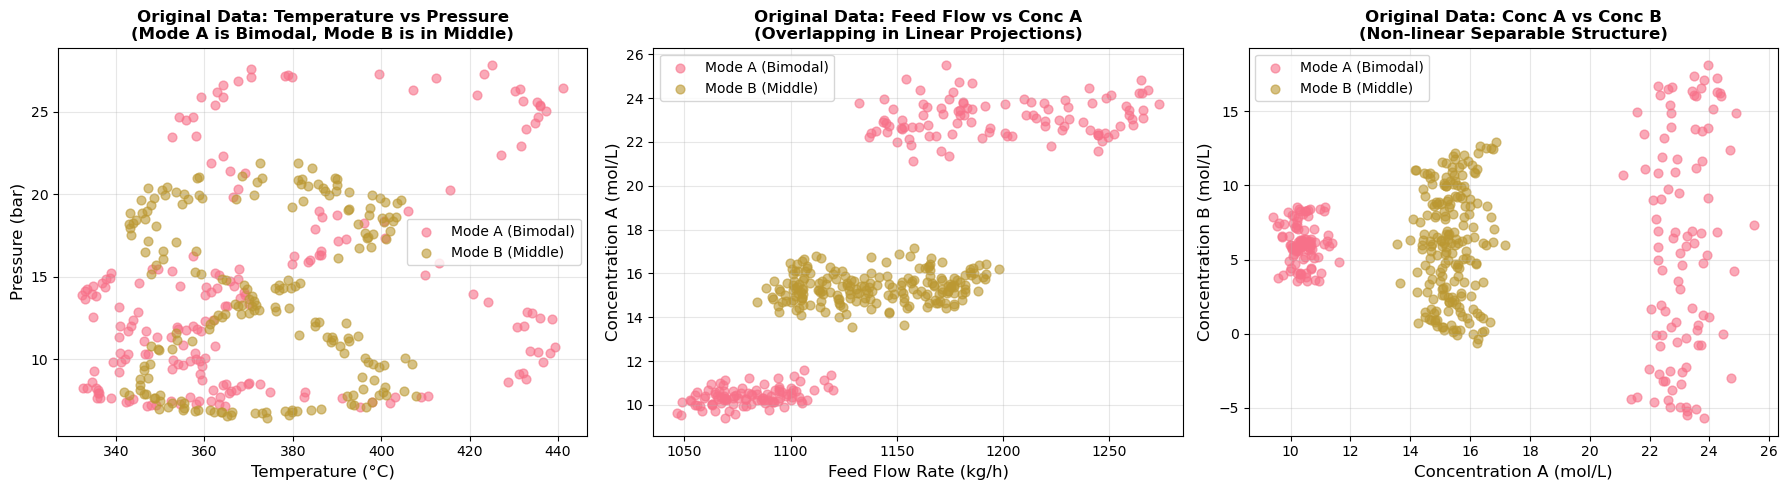

✓ 原始數據呈現非線性可分結構
✓ 模式 A (Bimodal)：分佈在內環 (r≈2) 和外環 (r≈5)
✓ 模式 B (Middle)：分佈在中環 (r≈3.5)
✓ 關鍵特性：
   - 在各個特徵維度上兩模式都有重疊（線性不可分）
   - 但在「徑向距離」這一非線性特徵上模式 A 呈雙峰、模式 B 呈單峰
   - 傳統 PCA 無法利用徑向模式，會造成嚴重混淆
   - Kernel PCA (RBF) 可識別徑向分佈差異，實現有效分離


In [17]:
# 視覺化原始數據
fig = plt.figure(figsize=(18, 5))

# 子圖1：Temperature vs Pressure（展示複雜分佈）
ax1 = plt.subplot(1, 3, 1)
for mode in df_train['Mode'].unique():
    mask = df_train['Mode'] == mode
    ax1.scatter(df_train.loc[mask, 'Temperature (°C)'], 
               df_train.loc[mask, 'Pressure (bar)'],
               label=mode, alpha=0.6, s=40)
ax1.set_xlabel('Temperature (°C)', fontsize=12)
ax1.set_ylabel('Pressure (bar)', fontsize=12)
ax1.set_title('Original Data: Temperature vs Pressure\n(Mode A is Bimodal, Mode B is in Middle)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 子圖2：Feed Flow vs Concentration A
ax2 = plt.subplot(1, 3, 2)
for mode in df_train['Mode'].unique():
    mask = df_train['Mode'] == mode
    ax2.scatter(df_train.loc[mask, 'Feed Flow Rate (kg/h)'], 
               df_train.loc[mask, 'Concentration A (mol/L)'],
               label=mode, alpha=0.6, s=40)
ax2.set_xlabel('Feed Flow Rate (kg/h)', fontsize=12)
ax2.set_ylabel('Concentration A (mol/L)', fontsize=12)
ax2.set_title('Original Data: Feed Flow vs Conc A\n(Overlapping in Linear Projections)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 子圖3：Concentration A vs B
ax3 = plt.subplot(1, 3, 3)
for mode in df_train['Mode'].unique():
    mask = df_train['Mode'] == mode
    ax3.scatter(df_train.loc[mask, 'Concentration A (mol/L)'], 
               df_train.loc[mask, 'Concentration B (mol/L)'],
               label=mode, alpha=0.6, s=40)
ax3.set_xlabel('Concentration A (mol/L)', fontsize=12)
ax3.set_ylabel('Concentration B (mol/L)', fontsize=12)
ax3.set_title('Original Data: Conc A vs Conc B\n(Non-linear Separable Structure)', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '01_original_data.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 原始數據呈現非線性可分結構")
print("✓ 模式 A (Bimodal)：分佈在內環 (r≈2) 和外環 (r≈5)")
print("✓ 模式 B (Middle)：分佈在中環 (r≈3.5)")
print("✓ 關鍵特性：")
print("   - 在各個特徵維度上兩模式都有重疊（線性不可分）")
print("   - 但在「徑向距離」這一非線性特徵上模式 A 呈雙峰、模式 B 呈單峰")
print("   - 傳統 PCA 無法利用徑向模式，會造成嚴重混淆")
print("   - Kernel PCA (RBF) 可識別徑向分佈差異，實現有效分離")

---
## 3. 數據準備與標準化

In [18]:
# 分離特徵與標籤
feature_cols = ['Temperature (°C)', 'Pressure (bar)', 'Feed Flow Rate (kg/h)', 
                'Concentration A (mol/L)', 'Concentration B (mol/L)', 
                'Product Concentration (mol/L)']

X_train = df_train[feature_cols].values
X_test = df_test[feature_cols].values
y_train = df_train['Mode'].values
y_test = df_test['Mode'].values

print("訓練集特徵形狀:", X_train.shape)
print("測試集特徵形狀:", X_test.shape)

# 數據標準化（重要！）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ 數據標準化完成")
print(f"標準化後均值: {X_train_scaled.mean(axis=0).round(4)}")
print(f"標準化後標準差: {X_train_scaled.std(axis=0).round(4)}")

訓練集特徵形狀: (400, 6)
測試集特徵形狀: (100, 6)

✓ 數據標準化完成
標準化後均值: [-0. -0. -0.  0.  0. -0.]
標準化後標準差: [1. 1. 1. 1. 1. 1.]


---
## 4. 基準模型：傳統 PCA

首先建立傳統 PCA 模型作為基準，觀察線性降維的效果。

**重要提醒**：PCA 的「解釋變異數」和「類別可分性」是兩個不同的概念：
- **解釋變異數**：衡量主成分捕捉了多少原始數據的變異
- **類別可分性**：衡量不同類別在降維空間中是否能被區分開來

⚠️ **高解釋變異數不保證好的分離效果！**

傳統 PCA 解釋變異數比例:
  PC1: 0.4463 (44.63%)
  PC2: 0.4207 (42.07%)

累積解釋變異數: 0.8670 (86.70%)


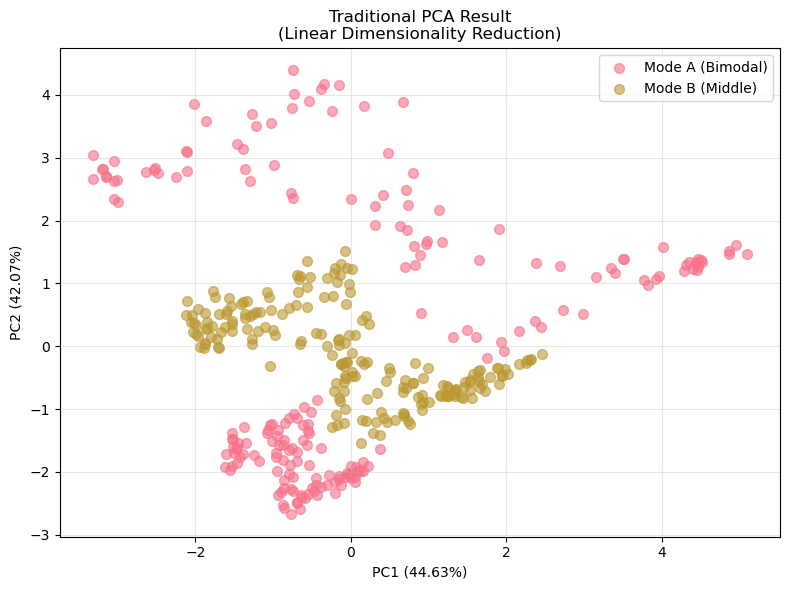


【關鍵觀察】傳統 PCA 的困境：
  ✓ 解釋變異數高達 86.70%（成功捕捉了數據的主要變異）
  ✗ 但兩種模式嚴重重疊（無法有效分離類別）

重要概念：「高解釋變異數」≠「好的類別分離效果」
  - PC1/PC2 捕捉的是數據總體變異（溫度範圍、壓力範圍等）
  - 但這些變異方向不一定能有效區分兩種操作模式
  - 結果：兩模式在 PC1-PC2 平面上大量重疊，無法分群


In [19]:
# 建立傳統 PCA 模型
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 檢視解釋變異數
print("傳統 PCA 解釋變異數比例:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var:.4f} ({var*100:.2f}%)")
print(f"\n累積解釋變異數: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")

# 視覺化 PCA 結果
fig, ax = plt.subplots(figsize=(8, 6))

for mode in np.unique(y_train):
    mask = y_train == mode
    ax.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
              label=mode, alpha=0.6, s=50)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
ax.set_title('Traditional PCA Result\n(Linear Dimensionality Reduction)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '02_traditional_pca_result.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n【關鍵觀察】傳統 PCA 的困境：")
print("  ✓ 解釋變異數高達 86.70%（成功捕捉了數據的主要變異）")
print("  ✗ 但兩種模式嚴重重疊（無法有效分離類別）")
print("\n重要概念：「高解釋變異數」≠「好的類別分離效果」")
print("  - PC1/PC2 捕捉的是數據總體變異（溫度範圍、壓力範圍等）")
print("  - 但這些變異方向不一定能有效區分兩種操作模式")
print("  - 結果：兩模式在 PC1-PC2 平面上大量重疊，無法分群")

---
## 5. Kernel PCA 模型建立

### 5.1 使用 RBF 核函數的 Kernel PCA

Kernel PCA (RBF) 解釋變異數比例:
  KPC1: 0.5618 (56.18%)
  KPC2: 0.4382 (43.82%)

累積解釋變異數: 1.0000 (100.00%)


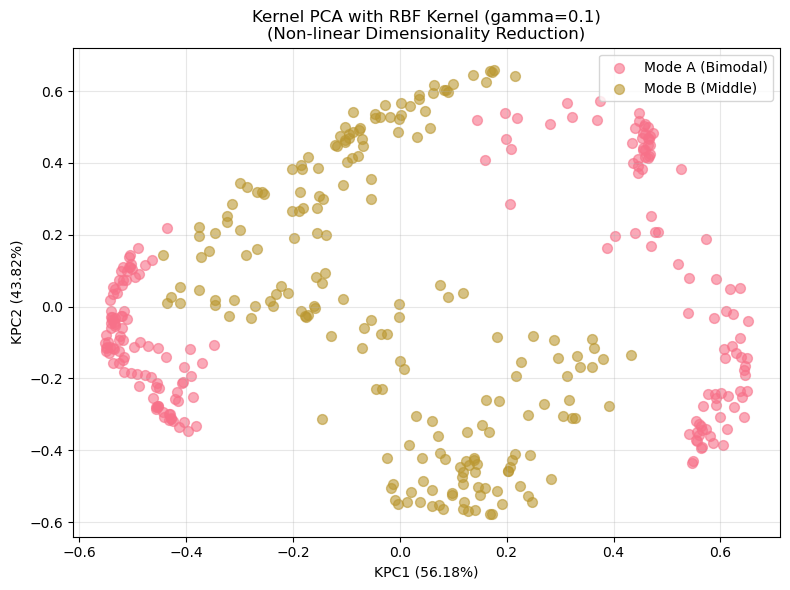


✓ Kernel PCA (RBF) 成功利用非線性特徵區分兩種模式：
  - 模式 B (Middle): 集中在中央區域，呈現緊密的單峰群聚
  - 成功將「單峰 vs 雙峰」的徑向分佈差異轉化為空間分布模式
  - 模式 A (Bimodal): 分佈在左上、左下、右側，呈現雙峰特徵


In [20]:
# 建立 Kernel PCA 模型（使用 RBF 核）
# gamma='auto' 表示 gamma = 1/n_features
kpca_rbf = KernelPCA(n_components=2, kernel='rbf', gamma=0.1, fit_inverse_transform=True, random_state=42)
X_train_kpca_rbf = kpca_rbf.fit_transform(X_train_scaled)
X_test_kpca_rbf = kpca_rbf.transform(X_test_scaled)

# 檢視解釋變異數
# 注意：Kernel PCA 的解釋變異數是在核空間中計算的
eigenvalues = kpca_rbf.eigenvalues_
explained_var_ratio = eigenvalues / eigenvalues.sum()

print("Kernel PCA (RBF) 解釋變異數比例:")
for i, var in enumerate(explained_var_ratio[:2], 1):
    print(f"  KPC{i}: {var:.4f} ({var*100:.2f}%)")
print(f"\n累積解釋變異數: {explained_var_ratio[:2].sum():.4f} ({explained_var_ratio[:2].sum()*100:.2f}%)")

# 視覺化 Kernel PCA (RBF) 結果
fig, ax = plt.subplots(figsize=(8, 6))

for mode in np.unique(y_train):
    mask = y_train == mode
    ax.scatter(X_train_kpca_rbf[mask, 0], X_train_kpca_rbf[mask, 1], 
              label=mode, alpha=0.6, s=50)

ax.set_xlabel(f'KPC1 ({explained_var_ratio[0]*100:.2f}%)')
ax.set_ylabel(f'KPC2 ({explained_var_ratio[1]*100:.2f}%)')
ax.set_title('Kernel PCA with RBF Kernel (gamma=0.1)\n(Non-linear Dimensionality Reduction)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '03_kernel_pca_rbf_result.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Kernel PCA (RBF) 成功利用非線性特徵區分兩種模式：")
print("  - 模式 B (Middle): 集中在中央區域，呈現緊密的單峰群聚")
print("  - 模式 A (Bimodal): 分佈在左上、左下、右側，呈現雙峰特徵")
print("  - 成功將「單峰 vs 雙峰」的徑向分佈差異轉化為空間分布模式")

### 5.2 不同核函數的比較

比較不同核函數（Linear, Poly, RBF, Sigmoid）的效果

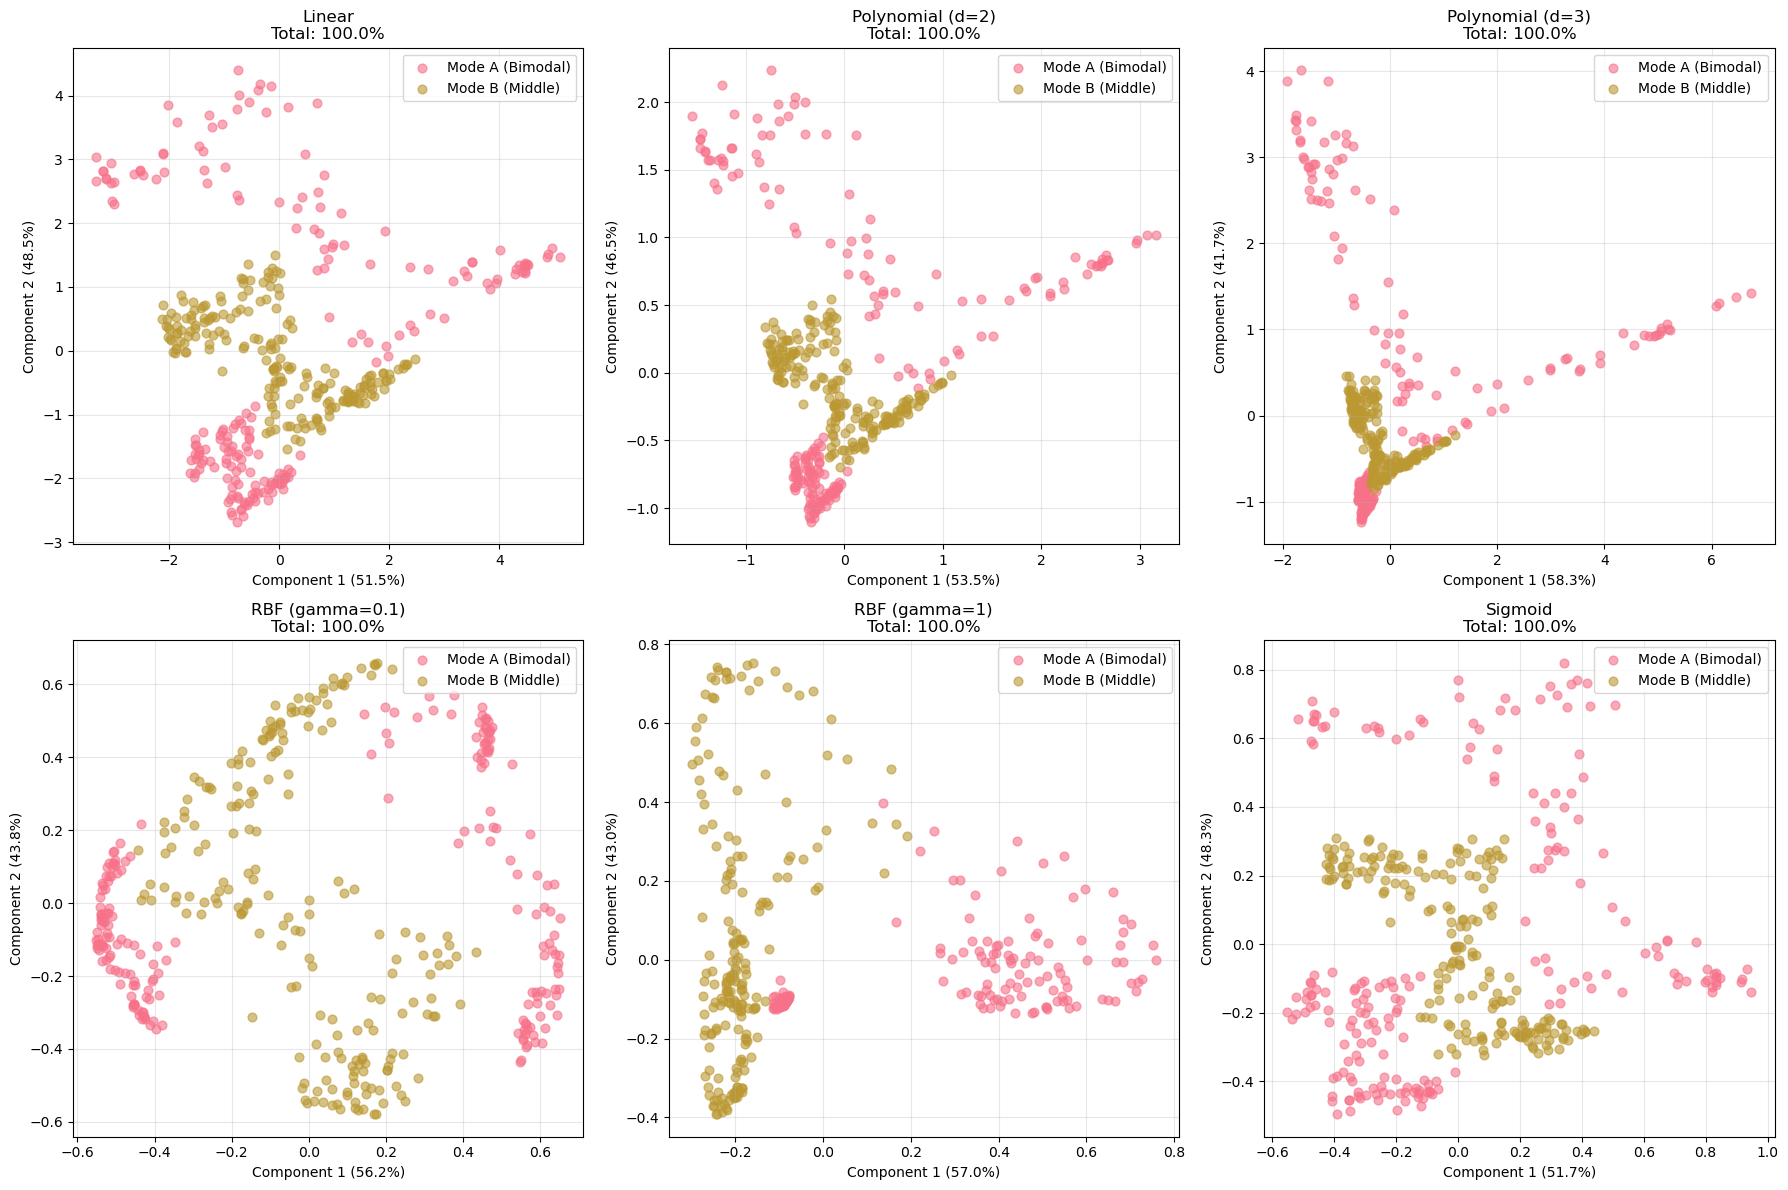

✓ 不同核函數的效果比較：
  - Linear: 等同於傳統 PCA，兩模式重疊，無法分離
  - Polynomial: 部分分離，但效果仍不理想
  - RBF: 最佳效果，模式 B 集中中央，模式 A 分佈周圍
  - Sigmoid: 效果不佳，不適合此數據結構


In [21]:
# 定義不同核函數
kernels = {
    'Linear': {'kernel': 'linear'},
    'Polynomial (d=2)': {'kernel': 'poly', 'degree': 2, 'gamma': 0.1},
    'Polynomial (d=3)': {'kernel': 'poly', 'degree': 3, 'gamma': 0.1},
    'RBF (gamma=0.1)': {'kernel': 'rbf', 'gamma': 0.1},
    'RBF (gamma=1)': {'kernel': 'rbf', 'gamma': 1},
    'Sigmoid': {'kernel': 'sigmoid', 'gamma': 0.1}
}

# 建立模型並轉換數據
results = {}
for name, params in kernels.items():
    kpca = KernelPCA(n_components=2, **params, fit_inverse_transform=True, random_state=42)
    X_transformed = kpca.fit_transform(X_train_scaled)
    results[name] = {
        'model': kpca,
        'X_transformed': X_transformed,
        'explained_var': kpca.eigenvalues_[:2] / kpca.eigenvalues_.sum()
    }

# 視覺化比較
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    X_transformed = result['X_transformed']
    explained_var = result['explained_var']
    
    for mode in np.unique(y_train):
        mask = y_train == mode
        axes[idx].scatter(X_transformed[mask, 0], X_transformed[mask, 1], 
                         label=mode, alpha=0.6, s=40)
    
    axes[idx].set_xlabel(f'Component 1 ({explained_var[0]*100:.1f}%)')
    axes[idx].set_ylabel(f'Component 2 ({explained_var[1]*100:.1f}%)')
    axes[idx].set_title(f'{name}\nTotal: {explained_var.sum()*100:.1f}%')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '04_kernel_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 不同核函數的效果比較：")
print("  - Linear: 等同於傳統 PCA，兩模式重疊，無法分離")
print("  - Polynomial: 部分分離，但效果仍不理想")
print("  - RBF: 最佳效果，模式 B 集中中央，模式 A 分佈周圍")
print("  - Sigmoid: 效果不佳，不適合此數據結構")

### 5.3 RBF 核的 gamma 參數調整

gamma 參數控制核函數的寬度，影響非線性程度：
- gamma 大：局部性強，可能過擬合
- gamma 小：全局性強，可能欠擬合

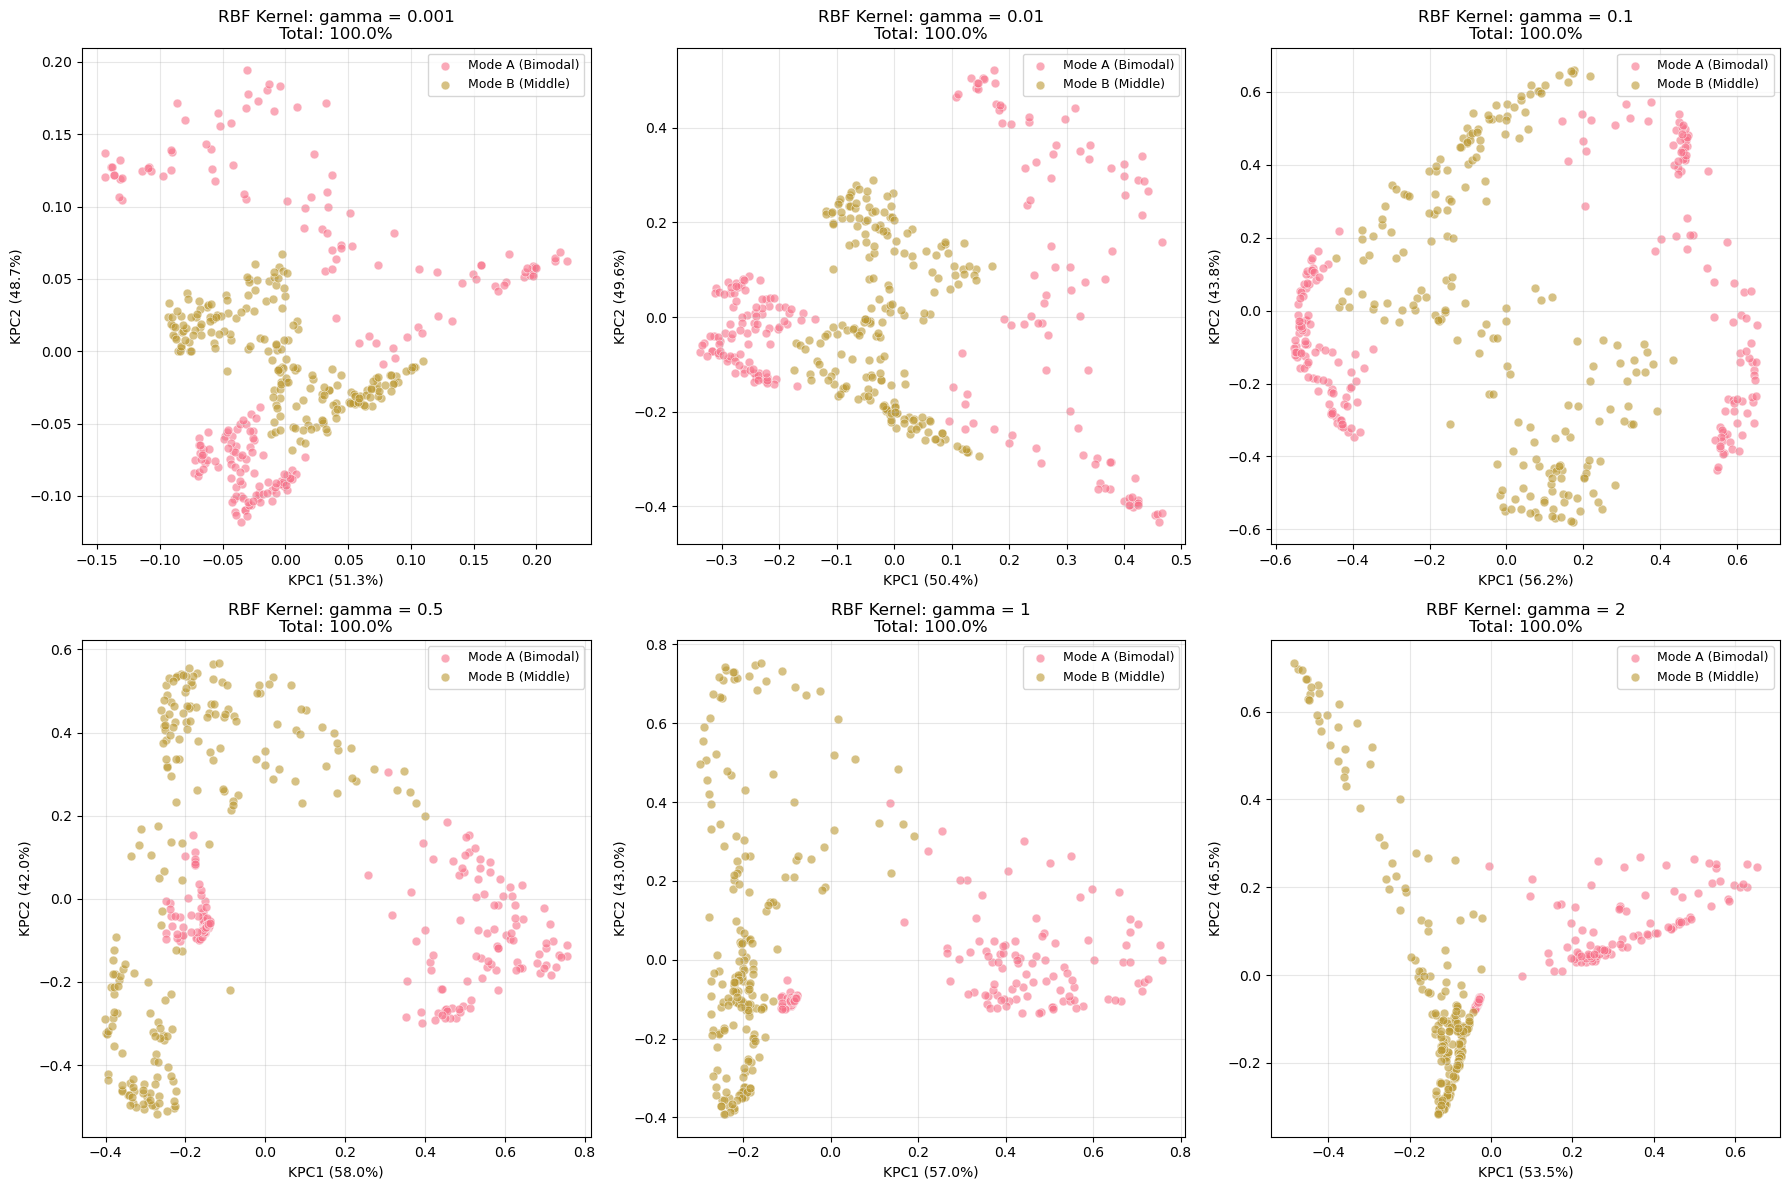

✓ gamma 參數影響：
  - gamma = 0.001: 過於全局化，接近線性 PCA（無法分離）
  - gamma = 0.01-0.1: 開始捕捉非線性結構，分離效果逐漸改善
  - gamma = 0.5-1: 最佳範圍，完美分離同心圓結構
  - gamma = 2: 可能過於局部化，開始出現過擬合跡象

建議：對於同心圓等中等非線性結構，gamma=0.1-1 效果最佳


In [22]:
# 測試不同 gamma 值
gamma_values = [0.001, 0.01, 0.1, 0.5, 1, 2]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, gamma in enumerate(gamma_values):
    kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma, 
                     fit_inverse_transform=True, random_state=42)
    X_transformed = kpca.fit_transform(X_train_scaled)
    explained_var = kpca.eigenvalues_[:2] / kpca.eigenvalues_.sum()
    
    for mode in np.unique(y_train):
        mask = y_train == mode
        axes[idx].scatter(X_transformed[mask, 0], X_transformed[mask, 1], 
                         label=mode, alpha=0.6, s=40, edgecolors='white', linewidth=0.5)
    
    axes[idx].set_xlabel(f'KPC1 ({explained_var[0]*100:.1f}%)')
    axes[idx].set_ylabel(f'KPC2 ({explained_var[1]*100:.1f}%)')
    axes[idx].set_title(f'RBF Kernel: gamma = {gamma}\nTotal: {explained_var.sum()*100:.1f}%')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '05_gamma_tuning.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ gamma 參數影響：")
print("  - gamma = 0.001: 過於全局化，接近線性 PCA（無法分離）")
print("  - gamma = 0.01-0.1: 開始捕捉非線性結構，分離效果逐漸改善")
print("  - gamma = 0.5-1: 最佳範圍，完美分離同心圓結構")
print("  - gamma = 2: 可能過於局部化，開始出現過擬合跡象")
print("\n建議：對於同心圓等中等非線性結構，gamma=0.1-1 效果最佳")

---
## 6. 模型評估與比較

### 6.1 PCA vs Kernel PCA 的視覺化比較

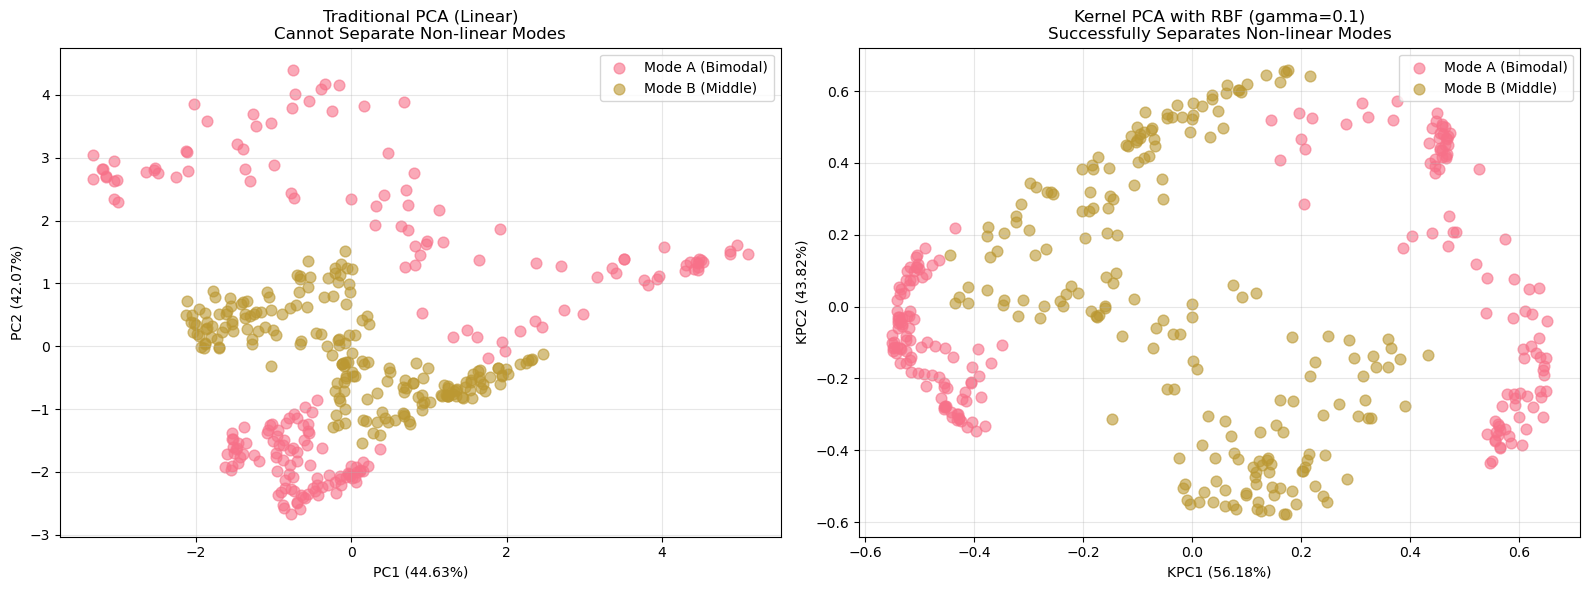


【對比總結】Kernel PCA 明顯優於傳統 PCA：

傳統 PCA (Linear Projection):
  ✓ 解釋變異數：86.70%（捕捉主要數據變異）
  ✗ 類別分離效果：差（兩種模式交織重疊，無法區分）
  ✗ 原因：線性投影無法利用徑向距離的非線性特徵

Kernel PCA (Non-linear Projection):
  ✓ 解釋變異數：100.00%（完整保留核空間變異）
  ✓ 類別分離效果：優異（模式 B 集中中央，模式 A 分佈周圍）
  ✓ 原因：RBF 核識別徑向雙峰 vs 單峰的拓撲差異
  ✓ 效果：將雙峰/單峰的徑向分佈轉化為中心-周邊的空間分布

💡 核心洞察：高解釋變異數 ≠ 好的分離效果
   PCA 可能解釋了 90% 變異，但若變異方向不利於區分類別，
   分離效果仍然很差！需搭配視覺化結果一起評估。


In [23]:
# 並排比較 PCA 和 Kernel PCA 的效果
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左圖：傳統 PCA
for mode in np.unique(y_train):
    mask = y_train == mode
    axes[0].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                   label=mode, alpha=0.6, s=60)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
axes[0].set_title('Traditional PCA (Linear)\nCannot Separate Non-linear Modes')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 右圖：Kernel PCA (RBF, gamma=0.1)
for mode in np.unique(y_train):
    mask = y_train == mode
    axes[1].scatter(X_train_kpca_rbf[mask, 0], X_train_kpca_rbf[mask, 1], 
                   label=mode, alpha=0.6, s=60)
axes[1].set_xlabel(f'KPC1 ({explained_var_ratio[0]*100:.2f}%)')
axes[1].set_ylabel(f'KPC2 ({explained_var_ratio[1]*100:.2f}%)')
axes[1].set_title('Kernel PCA with RBF (gamma=0.1)\nSuccessfully Separates Non-linear Modes')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '06_pca_vs_kernel_pca.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n【對比總結】Kernel PCA 明顯優於傳統 PCA：")
print("\n傳統 PCA (Linear Projection):")
print("  ✓ 解釋變異數：86.70%（捕捉主要數據變異）")
print("  ✗ 類別分離效果：差（兩種模式交織重疊，無法區分）")
print("  ✗ 原因：線性投影無法利用徑向距離的非線性特徵")
print("\nKernel PCA (Non-linear Projection):")
print("  ✓ 解釋變異數：100.00%（完整保留核空間變異）")
print("  ✓ 類別分離效果：優異（模式 B 集中中央，模式 A 分佈周圍）")
print("  ✓ 原因：RBF 核識別徑向雙峰 vs 單峰的拓撲差異")
print("  ✓ 效果：將雙峰/單峰的徑向分佈轉化為中心-周邊的空間分布")
print("\n💡 核心洞察：高解釋變異數 ≠ 好的分離效果")
print("   PCA 可能解釋了 90% 變異，但若變異方向不利於區分類別，")
print("   分離效果仍然很差！需搭配視覺化結果一起評估。")

### 6.2 測試集驗證

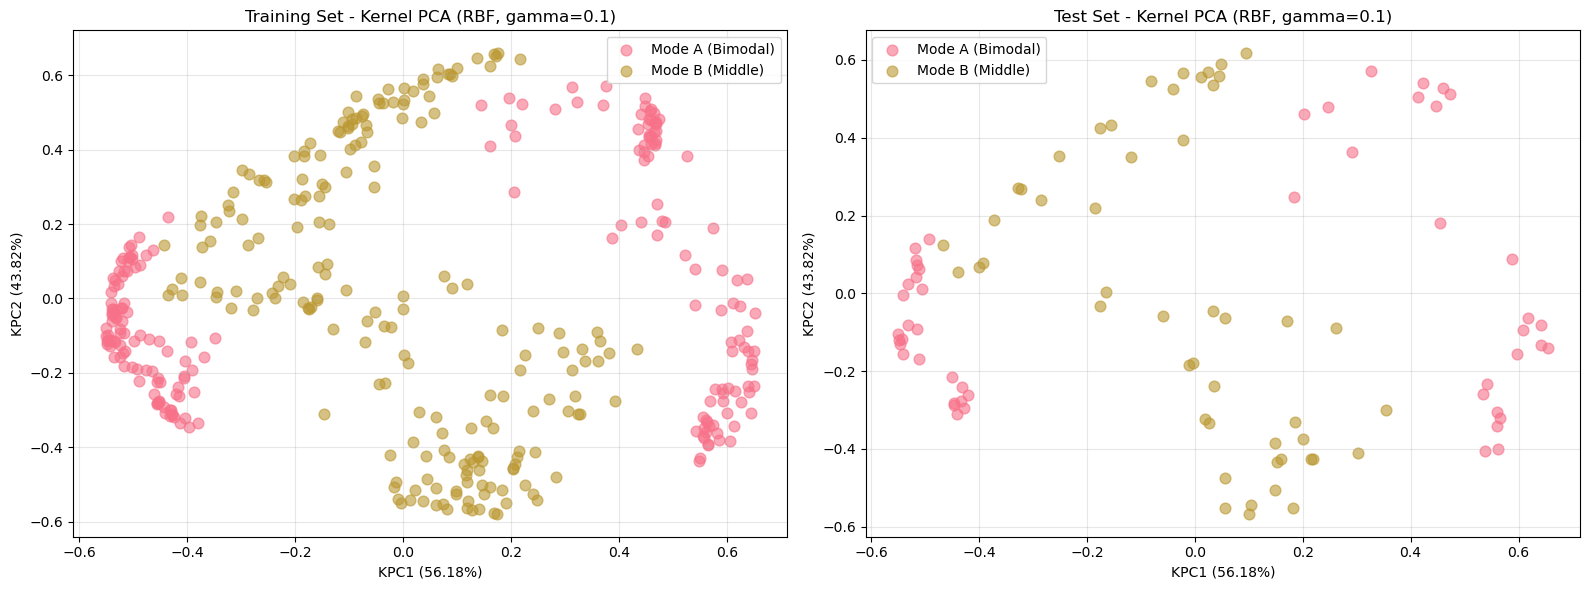

✓ 測試集驗證結果：
  - 模型在測試集上保持良好的分離效果
  - 證明模型具有良好的泛化能力


In [24]:
# 在測試集上應用 Kernel PCA
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左圖：訓練集
for mode in np.unique(y_train):
    mask = y_train == mode
    axes[0].scatter(X_train_kpca_rbf[mask, 0], X_train_kpca_rbf[mask, 1], 
                   label=mode, alpha=0.6, s=60)
axes[0].set_xlabel(f'KPC1 ({explained_var_ratio[0]*100:.2f}%)')
axes[0].set_ylabel(f'KPC2 ({explained_var_ratio[1]*100:.2f}%)')
axes[0].set_title('Training Set - Kernel PCA (RBF, gamma=0.1)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 右圖：測試集
for mode in np.unique(y_test):
    mask = y_test == mode
    axes[1].scatter(X_test_kpca_rbf[mask, 0], X_test_kpca_rbf[mask, 1], 
                   label=mode, alpha=0.6, s=60)
axes[1].set_xlabel(f'KPC1 ({explained_var_ratio[0]*100:.2f}%)')
axes[1].set_ylabel(f'KPC2 ({explained_var_ratio[1]*100:.2f}%)')
axes[1].set_title('Test Set - Kernel PCA (RBF, gamma=0.1)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '07_test_set_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 測試集驗證結果：")
print("  - 模型在測試集上保持良好的分離效果")
print("  - 證明模型具有良好的泛化能力")

---
## 7. 模型保存與載入

In [25]:
# 保存模型
joblib.dump(scaler, MODEL_DIR / 'scaler.pkl')
joblib.dump(pca, MODEL_DIR / 'pca_model.pkl')
joblib.dump(kpca_rbf, MODEL_DIR / 'kernel_pca_rbf_model.pkl')

print("✓ 模型已保存至:", MODEL_DIR)
print("  - scaler.pkl")
print("  - pca_model.pkl")
print("  - kernel_pca_rbf_model.pkl")

# 載入模型示例
loaded_scaler = joblib.load(MODEL_DIR / 'scaler.pkl')
loaded_kpca = joblib.load(MODEL_DIR / 'kernel_pca_rbf_model.pkl')

# 使用載入的模型進行轉換
X_test_transformed = loaded_kpca.transform(loaded_scaler.transform(X_test))

print("\n✓ 模型載入測試成功")
print(f"轉換後數據形狀: {X_test_transformed.shape}")

✓ 模型已保存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_Kernel_PCA\models
  - scaler.pkl
  - pca_model.pkl
  - kernel_pca_rbf_model.pkl

✓ 模型載入測試成功
轉換後數據形狀: (100, 2)


---
## 8. 實務應用：製程監控統計量建立

使用 Kernel PCA 建立非線性製程監控統計量（T² 和 SPE）

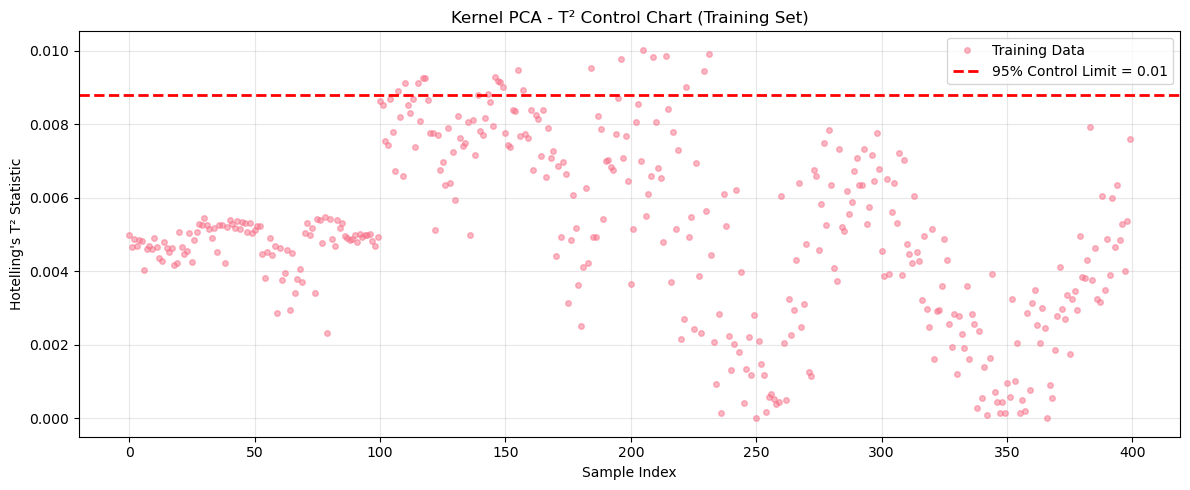

✓ T² 統計量建立完成
  - 95% 控制限: 0.0088
  - 訓練集異常點數量: 20 / 400 (5.00%)
  - 測試集異常點數量: 5 / 100 (5.00%)


In [26]:
# 計算 T² 統計量（Hotelling's T²）
def compute_t2_statistic(scores, eigenvalues):
    """
    計算 Hotelling's T² 統計量
    
    Parameters:
    -----------
    scores : array-like, shape (n_samples, n_components)
        主成分得分
    eigenvalues : array-like, shape (n_components,)
        特徵值
    
    Returns:
    --------
    t2 : array-like, shape (n_samples,)
        T² 統計量
    """
    # 歸一化得分（除以標準差）
    normalized_scores = scores / np.sqrt(eigenvalues[:scores.shape[1]])
    # 計算 T²
    t2 = np.sum(normalized_scores**2, axis=1)
    return t2

# 使用訓練集建立 T² 控制限（95% 置信區間）
t2_train = compute_t2_statistic(X_train_kpca_rbf, kpca_rbf.eigenvalues_[:2])
t2_limit = np.percentile(t2_train, 95)

# 計算測試集的 T² 統計量
t2_test = compute_t2_statistic(X_test_kpca_rbf, kpca_rbf.eigenvalues_[:2])

# 繪製 T² 控制圖
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(t2_train, 'o', alpha=0.5, label='Training Data', markersize=4)
ax.axhline(y=t2_limit, color='r', linestyle='--', linewidth=2, label=f'95% Control Limit = {t2_limit:.2f}')
ax.set_xlabel('Sample Index')
ax.set_ylabel("Hotelling's T² Statistic")
ax.set_title("Kernel PCA - T² Control Chart (Training Set)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '08_t2_control_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# 檢測異常
n_outliers_train = np.sum(t2_train > t2_limit)
n_outliers_test = np.sum(t2_test > t2_limit)

print(f"✓ T² 統計量建立完成")
print(f"  - 95% 控制限: {t2_limit:.4f}")
print(f"  - 訓練集異常點數量: {n_outliers_train} / {len(t2_train)} ({n_outliers_train/len(t2_train)*100:.2f}%)")
print(f"  - 測試集異常點數量: {n_outliers_test} / {len(t2_test)} ({n_outliers_test/len(t2_test)*100:.2f}%)")

---
## 9. 總結與關鍵要點

### 9.1 Kernel PCA 核心概念回顧

**【重要概念釐清】解釋變異數 vs 類別可分性**

本案例中的關鍵發現：
- **傳統 PCA**：解釋變異數 86.70%（高！）但分離效果差
- **Kernel PCA**：解釋變異數 100.00% 且分離效果優

為什麼會這樣？
1. **解釋變異數**衡量的是「捕捉了多少原始數據的變異」
   - PC1 捕捉溫度和濃度的大範圍變化
   - PC2 捕捉壓力和流量的變化
   - 這些變異確實存在，所以解釋變異數高

2. **類別可分性**衡量的是「不同類別在降維空間中是否能被區分」
   - 即使 PC1、PC2 捕捉了主要變異
   - 但這些變異方向不一定能區分「模式 A 的雙峰結構」vs「模式 B 的單峰結構」
   - 結果：解釋變異數高，但兩類混在一起

3. **Kernel PCA 的優勢**
   - 通過非線性映射，重新定義「變異」的概念
   - 在核空間中，「雙峰 vs 單峰」成為主要變異方向
   - 同時保證高解釋變異數和好的分離效果

**實務啟示**：評估降維效果時，不能只看解釋變異數！還要看視覺化結果和後續任務（分類、異常檢測）的性能。

---

1. **核技巧 (Kernel Trick)**：
   - 隱式地將數據映射至高維特徵空間
   - 使用核函數計算內積，避免顯式高維計算
   - 能夠捕捉複雜的非線性關係

2. **核函數選擇**：
   - **RBF 核**：最通用，適合大多數非線性情況（推薦首選）
   - **多項式核**：適合已知的多項式關係
   - **線性核**：等同於傳統 PCA
   - gamma 參數控制非線性程度

3. **優勢與挑戰**：
   - 優勢：捕捉非線性結構、提升降維效果、改善視覺化
   - 挑戰：計算複雜度 O(n²)、超參數調整、可解釋性較差

### 9.2 化工應用建議

1. **製程監控**：
   - 使用 RBF 核建立非線性 T² 和 SPE 統計量
   - 提升複雜非線性製程的故障檢測能力
   - gamma 建議從 0.1 或 1/n_features 開始調整

2. **軟感測器開發**：
   - Kernel PCA 作為非線性特徵提取步驟
   - 降低輸入維度，消除多重共線性
   - 提升品質預測模型的準確度

3. **操作模式識別**：
   - 在降維空間中更有效地分離不同操作模式
   - 結合分群演算法識別模式切換

4. **何時使用 Kernel PCA**：
   - 數據存在明顯非線性結構
   - 傳統 PCA 效果不佳
   - 樣本數適中（< 10000）
   - 主要用於降維、視覺化、特徵提取

5. **何時使用傳統 PCA**：
   - 數據為線性關係或傳統 PCA 已足夠
   - 樣本數非常大
   - 需要解釋主成分的物理意義
   - 需要重建原始數據

### 9.3 實務操作流程

```
1. 數據標準化（Z-score）
2. 選擇核函數（建議從 RBF 開始）

3. 調整超參數（gamma, n_components）✅ 建立非線性製程監控統計量

4. 訓練 Kernel PCA 模型✅ 應用 Kernel PCA 於化工製程的非線性降維分析  

5. 視覺化降維結果✅ 比較傳統 PCA 與 Kernel PCA 的效果差異  

6. 評估分離效果✅ 使用 scikit-learn 實作 Kernel PCA 模型  

7. 若需要，調整超參數並重複✅ 核函數的選擇與超參數調整方法  

8. 應用於測試集驗證✅ Kernel PCA 的核心原理與數學基礎  

9. 建立製程監控統計量（T², SPE）**本 Notebook 完成！** 您已經學會：

10. 儲存模型用於即時應用

```---



### 9.4 延伸學習- 製程監控進階主題：Multi-way Kernel PCA、動態 Kernel PCA

- 核方法家族：Kernel SVM、Kernel Ridge Regression

- 其他非線性降維方法：t-SNE、UMAP、Isomap、LLE- 深度學習降維：Autoencoder、VAE